In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
def convolution(image, kernel, stride=1, padding=0, activation='relu'):
    h, w = kernel.shape[:2]
    H, W, channels = image.shape

    if padding > 0:
        image = np.pad(image, ((padding, padding),
                       (padding, padding), (0, 0)), 'constant')

    # Compute output dimensions
    outputHeight = (H - h + 2*padding) // stride + 1
    outputWeight = (W - w + 2*padding) // stride + 1

    output = np.zeros((outputHeight, outputWeight))

    for i in range(0, H-h+1, stride):
        for j in range(0, W-w+1, stride):
            conv = 0
            for c in range(channels):

                region = image[i:i+h, j:j+w, c]

                conv = conv + np.sum(region * kernel[:, :, c])

            if activation == 'sigmoid':
                conv = 1 / (1 + np.exp(-conv))
            elif activation == 'tanh':
                conv = np.tanh(conv)
            elif activation == 'relu':
                conv = np.maximum(0, conv)
            elif activation == 'prelu':
                alpha = 0.1  
                conv = np.maximum(0, conv) + alpha * np.minimum(0, conv)

            output[i//stride, j//stride] = conv

    return output

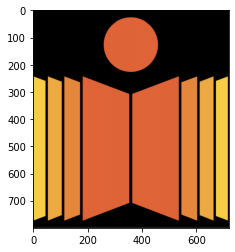

In [180]:
from matplotlib import image
img = image.imread('iith.png')
plt.imshow(img)
plt.show()

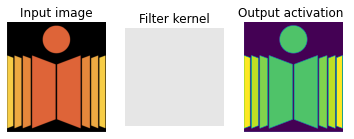

In [182]:
kernel = np.ones((3,3,4)) /9
output = convolution(img, kernel)
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Input image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(kernel)
plt.title('Filter kernel')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(output)
plt.title('Output activation ')
plt.axis('off')

plt.show()

In [183]:
def pooling(activation_map, kernel_shape, stride=None, pooling_type='max'):

    # get the shape of activation map
    H, W = activation_map.shape
    if type(kernel_shape) == int:
        h = w = kernel_shape
    else:
       h, w = kernel_shape
    if stride == None:
        stride = w

    # compute the output dimensions
    o_h = (H - h) // stride + 1
    o_w = (W - w) // stride + 1

    # initialize the output matrix
    output = np.zeros((o_h, o_w))

    # loop over the activation map
    for i in range(0, H-h+1, stride):
        for j in range(0, W-w+1, stride):
            region = activation_map[i:i+h, j:j+w]
            if pooling_type == 'max':
                output[i//stride, j//stride] = np.max(region)
            elif pooling_type == 'avg':
                output[i//stride, j//stride] = np.mean(region)

    return output

(159, 143)


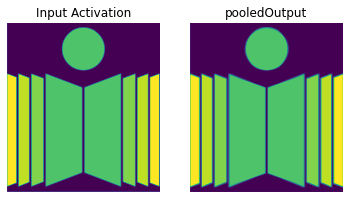

In [185]:
pooledOutput = pooling(output, kernel_shape=5, pooling_type='avg')
print(pooledOutput.shape)
plt.subplot(1, 2, 1)
plt.imshow(output)
plt.title('Input Activation')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pooledOutput)
plt.title('pooledOutput')
plt.axis('off')

plt.show()

In [186]:
class ConvolutionalLayer:
    def __init__(self,input_shape, num_filters, kernel_size, stride=1, padding=0, activation='relu'):
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.filter_shape = (self.kernel_size, self.kernel_size, input_shape[2], self.num_filters)
        self.filter_bank = np.random.randn(*self.filter_shape)
        self.input_volume = None
        self.output_volume = None

    def compute_output_shape(self, input_shape):
        output_height = (input_shape[0] - self.kernel_size + 2*self.padding) // self.stride + 1
        output_width = (input_shape[1] - self.kernel_size + 2*self.padding) // self.stride + 1
        return (output_height, output_width, self.num_filters)

    def forward(self, input_volume):
        self.input_volume = input_volume
        output_shape = self.compute_output_shape(input_volume.shape)
        self.output_volume = np.zeros(output_shape)
        for f in range(self.num_filters):
            filter_kernel = self.filter_bank[:, :, :, f]
            output = convolution(input_volume, filter_kernel, self.stride, self.padding,self.activation)
            self.output_volume[:, :, f] = output
        return self.output_volume



In [188]:
conv_layer = ConvolutionalLayer(input_shape=img.shape,num_filters=4, kernel_size=3, stride=1,activation='sigmoid')
output_volume = conv_layer.forward(img)
output_volume.shape

(798, 718, 4)

In [22]:
class PoolingLayer:
    def __init__(self, kernel_size, stride=None, pooling_type='max'):
        self.kernel_size = kernel_size
        self.stride = stride or kernel_size[0]
        self.pooling_type = pooling_type
        self.input_volume = None
        self.output_volume = None
    
    def forward(self, input_volume):
        self.input_volume = input_volume
        output_shape = ((self.input_volume.shape[0] - self.kernel_size[0]) // self.stride + 1,
                        (self.input_volume.shape[1] - self.kernel_size[1]) // self.stride + 1,
                        self.input_volume.shape[-1])
        self.output_volume = np.zeros(output_shape)
        for f in range(self.input_volume.shape[-1]):
            filter_kernel = self.input_volume[:, :, f]
            output = pooling(filter_kernel, self.kernel_size, self.stride, self.pooling_type)
            self.output_volume[:, :, f] = output
        return self.output_volume


For Global Average pooling layer kernel_size=img.shape and pooling_type = avg

In [66]:
# Create pooling layer
pooling_layer = PoolingLayer(kernel_size=(2,2), pooling_type='max')

# Apply max pooling
pooled_output_volume = pooling_layer.forward(output_volume)
pooled_output_volume.shape




(399, 359, 10)

In [189]:
class FlattenLayer:
    def __init__(self):
        pass

    def forward(self, input_volume):
        self.input_volume = input_volume
        self.output_volume = input_volume.flatten()
        self.weights = np.random.randn(self.output_volume.shape[0], 8)
        return np.matmul(self.output_volume, self.weights)


In [190]:
flat = FlattenLayer()
presdb = flat.forward(pooled_output_volume)
presdb

array([1441.52609667, -242.95674108,    8.38481612,   47.92820893,
       -340.82040939, 1291.73541221, -156.26752131, -320.1105316 ])

In [191]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, hidden_activation='relu', apply_softmax=True):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases for input-hidden and hidden-output layers
        self.weights_ih = np.random.randn(hidden_size, input_size)
        self.biases_ih = np.random.randn(hidden_size)
        self.weights_ho = np.random.randn(output_size, hidden_size)
        self.biases_ho = np.random.randn(output_size)

        # Set activation function for hidden layer
        self.hidden_activation = self.get_activation_function(
            hidden_activation)

        # Set whether to apply softmax to output layer
        self.apply_softmax = apply_softmax

    def forward(self, x):
        # Calculate input-hidden layer output
        hidden_output = np.dot(self.weights_ih, x) + self.biases_ih
        hidden_output = self.hidden_activation(hidden_output)

        # Calculate hidden-output layer output
        output = np.dot(self.weights_ho, hidden_output) + self.biases_ho
        if self.apply_softmax:
            output = self.softmax(output).reshape(self.output_size,)

        return output.reshape(self.output_size,)

    def get_activation_function(self, activation):
        if activation == 'relu':
            return self.relu
        elif activation == 'sigmoid':
            return self.sigmoid
        elif activation == 'prelu':
            return self.prelu
        elif activation == 'tanh':
            return self.tanh
        else:
            raise ValueError(f'Invalid activation function: {activation}')

    def relu(self, x):
        return np.maximum(0, x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def prelu(self, x):
        alpha = 0.1  # PReLU parameter
        return np.maximum(0, x) + alpha * np.minimum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def softmax(self, x):
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x)

In [193]:
#Testing MLP
mlp = MLP(3, 4, 5, hidden_activation='relu', apply_softmax=True)
x = np.array([1, 2,3])
output = mlp.forward(x)
print(output)

[9.39645499e-01 2.08302091e-05 5.54074237e-02 4.74207829e-08
 4.92619930e-03]


In [194]:
class ConvolutionalNeuralNetwork:

    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.layers = []

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, input_volume):
        for layer in self.layers:
            input_volume = layer.forward(input_volume)
        return input_volume

In [195]:
cnn = ConvolutionalNeuralNetwork(num_classes=10)
cnn.add_layer(ConvolutionalLayer(input_shape=(32,32,3),num_filters=16,kernel_size=3,activation='sigmoid'))
cnn.add_layer(PoolingLayer(kernel_size=(2,2), pooling_type='max'))
cnn.add_layer(ConvolutionalLayer(input_shape=(15, 15, 16),num_filters=8,kernel_size=3,activation='sigmoid'))
cnn.add_layer(PoolingLayer(kernel_size=(2,2), pooling_type='max'))
cnn.add_layer(PoolingLayer(kernel_size=(6,6), pooling_type='avg'))
cnn.add_layer(FlattenLayer())
cnn.add_layer(MLP(8, 8, 10, hidden_activation='relu', apply_softmax=True))

bird = image.imread('bird.png')
print(bird.shape)
output = cnn.forward(bird)
output

(32, 32, 3)


array([1.64273102e-10, 3.28191626e-07, 6.10483613e-10, 4.73874066e-10,
       9.99998112e-01, 5.45982713e-16, 8.49246391e-19, 1.51187367e-06,
       6.13991774e-10, 4.56815523e-08])

In [196]:
#LOAD CIFAR-10 Data

import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    data = []
    labels = []
    for i in range(len(dict[b'labels'])):
        label = dict[b'labels'][i]
        data.append(dict[b'data'][i])
        labels.append(label)
    return data, labels

file = 'data_batch_1'
data, labels = unpickle(file)
class_data = [[] for i in range(10)]
for i in range(10):
    class_label = i
    class_data[i] = [data[j]
                     for j in range(len(data)) if labels[j] == class_label]

(32, 32, 3)


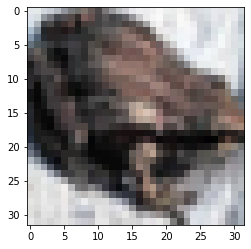

In [198]:
#plot 5th image of 6th label(frog)
img = class_data[6][5]
img = np.reshape(img, (3, 32, 32))
img = np.transpose(img, (1, 2, 0))
print(img.shape)
plt.imshow(img)
plt.show()

In [199]:
output=[]
for i in range(10):
  img = class_data[i][5]
  img = np.reshape(img, (3, 32, 32))
  img = np.transpose(img, (1, 2, 0))
  output.append(cnn.forward(img))
output

<ipython-input-42-a6b610588910>:25: RuntimeWarning: overflow encountered in exp
  conv = 1 / (1 + np.exp(-conv))


[array([1.88400409e-05, 3.71313598e-03, 1.71577576e-17, 5.29036886e-03,
        1.14942005e-07, 8.48917718e-17, 1.05561050e-13, 9.89919008e-01,
        9.89433745e-24, 1.05853168e-03]),
 array([1.04216873e-08, 1.59531464e-10, 1.86912692e-12, 3.01957144e-11,
        9.99999837e-01, 2.87552140e-18, 2.49660854e-18, 6.38048346e-09,
        1.58040414e-12, 1.45525351e-07]),
 array([0.03703496, 0.0279022 , 0.05196998, 0.41879171, 0.33886517,
        0.01276686, 0.00234843, 0.07213339, 0.00969791, 0.02848939]),
 array([4.27550045e-11, 9.76196416e-01, 3.08057209e-06, 3.95255687e-03,
        2.88898911e-05, 7.21428510e-10, 2.23205878e-14, 1.98183437e-02,
        4.96615091e-12, 7.12153680e-07]),
 array([3.46393309e-04, 5.89508541e-04, 1.54057509e-11, 8.01391087e-04,
        8.29612786e-07, 3.33128425e-13, 6.08264185e-12, 9.60947028e-01,
        2.41644495e-18, 3.73148492e-02]),
 array([4.41328279e-03, 9.48168024e-03, 1.94692662e-10, 2.64002041e-04,
        1.43758535e-01, 3.80639628e-13, 6.8802

From the Above oupt vectors for each class we can derive that as in each vector one or more classes have a probability that is much higher than probabilities of other classes,this implies classes are easily separable and distinct



In [200]:
add_cnn = ConvolutionalNeuralNetwork(num_classes=10)
add_cnn.add_layer(ConvolutionalLayer(input_shape=(32,32,3),num_filters=16,kernel_size=3,activation='sigmoid'))
add_cnn.add_layer(PoolingLayer(kernel_size=(2,2), pooling_type='max'))
add_cnn.add_layer(ConvolutionalLayer(input_shape=(15, 15, 16),num_filters=8,kernel_size=3,activation='sigmoid'))
add_cnn.add_layer(PoolingLayer(kernel_size=(2,2), pooling_type='max'))
add_cnn.add_layer(PoolingLayer(kernel_size=(6,6), pooling_type='avg')) # Global Avg Pooling
add_cnn.add_layer(FlattenLayer())
 
output=np.empty((10,3),dtype=object)
for i in range(10):
  for j in range(3):
    img = class_data[i][j]
    img = np.reshape(img, (3, 32, 32))
    img = np.transpose(img, (1, 2, 0))
    value = add_cnn.forward(img)
    output[i,j]= value
output

<ipython-input-42-a6b610588910>:25: RuntimeWarning: overflow encountered in exp
  conv = 1 / (1 + np.exp(-conv))


array([[array([ 0.26238721, -1.58652914,  2.30233288,  0.67379657,  1.56263311,
               -2.70971286, -1.42719964, -0.9962528 ])                         ,
        array([ 2.26609131, -1.97374451,  0.52842012,  0.88216366, -0.36088348,
               -1.33659592, -0.61559742, -1.84434891])                         ,
        array([-1.19253295, -3.30196826, -0.79202199,  1.464156  , -0.87752297,
                0.15341077,  0.20847774,  4.39793258])                         ],
       [array([-0.49640831, -1.30646777, -1.37772841,  0.64507396, -2.52585258,
               -1.56853694, -4.64298586,  3.23815679])                         ,
        array([ 1.13043315,  0.91620403, -1.54933751, -0.81039783, -1.64788129,
                1.15563062, -1.61463624, -0.38139377])                         ,
        array([-0.8864228 ,  2.16189639, -2.10547614,  2.37286723, -1.57007253,
                0.84256881, -1.34526047, -2.72148439])                         ],
       [array([ 1.66518971, -0.5

In [201]:
#converting the outpt to a 2d array
output_array = np.full((10, 8), np.nan)  # create new array filled with nan values
for i in range(10):
    for j in range(3):
        seq = output[i, j]
        output_array[i, :len(seq)] = seq  # fill in values from output
output_array

array([[-1.19253295, -3.30196826, -0.79202199,  1.464156  , -0.87752297,
         0.15341077,  0.20847774,  4.39793258],
       [-0.8864228 ,  2.16189639, -2.10547614,  2.37286723, -1.57007253,
         0.84256881, -1.34526047, -2.72148439],
       [ 0.1417095 , -0.29492779,  0.83801874,  0.52814954, -2.17769937,
        -1.47079406, -0.18274418, -0.09318348],
       [-0.40482416,  0.35262697, -0.14674118, -2.62280444,  2.18562399,
        -0.80383185, -0.30011494,  0.75515388],
       [-0.03035035, -1.11965867,  0.56676111,  0.7992198 ,  0.16958137,
         1.08128373,  0.93682903,  1.3026945 ],
       [-0.39054141,  2.42312419, -0.78416456, -1.13775729, -2.01645   ,
         0.04715563, -0.28806217,  1.28830671],
       [-0.44743718,  1.40457868,  0.93050929,  0.19592242,  1.36944339,
         0.74522551,  1.46546512, -1.27721   ],
       [-2.19291614, -1.05628865, -1.49826991, -0.4011579 ,  1.47778313,
         0.7971652 ,  1.16532203, -0.45302157],
       [ 0.45520104,  0.82708181

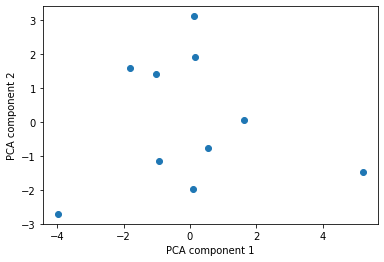

In [202]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Compute PCA
pca = PCA(n_components=2)
pca.fit(output_array)
X_pca = pca.transform(output_array)

# Plot results
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.show()

From the above plot we can observe the points (labels) are distant ,it implies similarities between them is low but for some labels like animal we can see the points are nearer as they have some similarities